In [39]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, recall_score

from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from scipy import stats
import statsmodels.api as sm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBRFClassifier
from sklearn.metrics import roc_auc_score

In [10]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [11]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [12]:
def na_check(data):
    check = np.round(data.isna().sum().sort_values(ascending=False),2)
    return check

In [13]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [14]:
# get a list of models to evaluate
def get_models():
    models = dict()
# define the number of trees to consider
    n_trees = [10, 50, 100, 250]
    for v in n_trees:
        models[str(v)] = XGBRFClassifier(n_estimators=v, subsample=0.9, colsample_bynode=0.2)
    return models
 
# evaluate a give model using cross-validation
def evaluate_xg_model(model, X, y):
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    return scores


In [15]:
def modelfit(model, x, y, features, xval, yval, useTrainCV=True, cv_folds=3, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(x[features], label=y.loan_status.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=1, nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval=True)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model.fit(x[features], y.loan_status,eval_set=[(x[features],y.loan_status.values),(xval[features],yval.loan_status.values)],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = model.predict(x[features])
    dtrain_predprob = model.predict_proba(x[features])[:,1]
    
     #Predict training set:
    dval_predictions = model.predict(xval[features])
    dval_predprob = model.predict_proba(xval[features])[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(y['loan_status'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(y['loan_status'], dtrain_predprob))
    print ("Recall Score (Train): %f" % recall_score(y['loan_status'], dtrain_predictions))
    
    print ("Accuracy : %.4g" % accuracy_score(y['loan_status'].values, dval_predictions))
    print ("AUC Score (Val): %f" % roc_auc_score(y['loan_status'], dval_predprob))
    print ("Recall Score (Val): %f" % recall_score(y['loan_status'], dval_predictions))
                    
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
def model_results(x_test,y_test,features,model):
    y_hat = model.predict(x_test[features])
    cf = confusion_matrix(y_test,y_hat)
    plot_confusion_matrix(model,x_test[features],y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
    plt.title("{} Confusion Matrix".format(model))

    print(confusion_matrix(y_test, y_hat))
    print(classification_report(y_test, y_hat))

In [19]:
df = pd.read_csv('data/full_clean_pre_z')
df.drop('Unnamed: 0',axis=1,inplace=True)
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Memory usage of dataframe is 662.59 MB


100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


Memory usage after optimization is: 374.363 MB
Decreased by 43.5%


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,12000.0,36,10.99,392.799988,B,B2,4,RENT,60000.0,Not Verified,...,0.0,0.0,4.0,100.000000,0.0,7137.0,18100.0,0.0,722.0,South
1,4800.0,36,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,Source Verified,...,0.0,0.0,0.0,100.000000,0.0,4136.0,25700.0,0.0,757.0,South
2,27060.0,36,10.99,885.500000,B,B2,10,OWN,55000.0,Verified,...,0.0,0.0,1.0,100.000000,0.0,70186.0,35700.0,33054.0,732.0,Midwest
3,12000.0,36,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,Not Verified,...,0.0,0.0,3.0,100.000000,0.0,46738.0,14800.0,53404.0,707.0,South
4,14000.0,36,12.85,470.799988,B,B4,4,RENT,88000.0,Not Verified,...,0.0,0.0,0.0,78.599998,1.0,17672.0,3900.0,27340.0,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,24000.0,60,23.99,690.500000,E,E2,1,RENT,107000.0,Source Verified,...,0.0,1.0,2.0,87.500000,1.0,60812.0,28200.0,64422.0,672.0,West
1736933,10000.0,36,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,Source Verified,...,0.0,0.0,2.0,92.599998,0.0,55863.0,34800.0,70203.0,727.0,Northeast
1736934,10050.0,36,16.99,358.200012,D,D1,8,RENT,37000.0,Not Verified,...,0.0,0.0,5.0,95.199997,0.0,14300.0,9000.0,0.0,707.0,South
1736935,6000.0,36,11.44,197.800003,B,B4,5,RENT,41000.0,Source Verified,...,0.0,0.0,1.0,94.400002,0.0,26201.0,8100.0,34076.0,672.0,Northeast


In [21]:
#list of categorical variables to get ohe
categorical = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region']


cat_drop = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region','loan_status']

In [22]:
cont_columns = df.drop(columns=cat_drop).columns

In [23]:
# removing outliers greater than 4 std deviations to standardize
df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<4).all(axis=1)]
z_score_df = df.loc[df_cont_z.index]

In [24]:
onehot = pd.get_dummies(z_score_df[categorical],drop_first=True)

In [25]:
cont = z_score_df.drop(columns=cat_drop)


In [26]:
x= pd.concat([cont,onehot],axis=1)
y= z_score_df['loan_status'].map(lambda x: 1 if x== "Charged Off" else 0)

In [27]:
#splitting our x and y into training and testing samples
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

In [28]:
#importing our priorly smoted x train and y train samples
x_smote = pd.read_csv('data/x_smote_z')
y_smote = pd.read_csv('data/y_smote_z')

In [29]:
# as we dropped columns after testing to our original df need to drop from smote so they aren't included in smote modeling
# at end will need to re run smote 
x_smote.drop(columns=['Unnamed: 0','total_rec_int','total_rec_prncp','total_pymnt',
                 'tot_coll_amt','num_il_tl','delinq_amnt','tax_liens','last_pymnt_amnt'],axis=1,inplace=True)

In [30]:
reduce_mem_usage(x_smote,int_cast=False)

  0%|          | 0/106 [00:00<?, ?it/s]

Memory usage of dataframe is 1314.89 MB


100%|██████████| 106/106 [00:25<00:00,  4.16it/s]


Memory usage after optimization is: 350.430 MB
Decreased by 73.3%


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,region_Northeast,region_South,region_West
0,7750.000000,36,10.990000,253.800003,3,29000.000000,25.200001,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
1,10000.000000,36,22.910000,386.799988,1,72000.000000,8.200000,1.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,10000.000000,36,12.990000,337.000000,6,40000.000000,22.500000,0.000000,2.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
3,5500.000000,36,16.549999,194.899994,4,54224.000000,20.440001,0.000000,2.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,25000.000000,36,14.520000,861.000000,5,75000.000000,24.980000,0.000000,2.000000,1.000000,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625891,24366.757812,51,17.206345,707.872986,4,117479.695312,21.083889,0.633242,1.100275,0.000000,...,0,0,0,0,0,0,0,0,1,0
1625892,19482.703125,50,15.419235,542.377869,5,51204.097656,22.845705,0.000000,0.602049,0.602049,...,0,0,0,0,0,0,0,0,0,0
1625893,13179.145508,36,14.562667,461.734833,6,55000.000000,18.415403,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1625894,17840.857422,45,21.473141,597.083801,8,54589.417969,23.626722,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y_smote.drop('Unnamed: 0',axis=1,inplace=True)
reduce_mem_usage(y_smote,int_cast=False)

100%|██████████| 1/1 [00:00<00:00, 66.63it/s]

Memory usage of dataframe is 12.40 MB


Memory usage after optimization is: 1.551 MB
Decreased by 87.5%


,loan_status
0,0
1,1
2,0
3,1
4,1
...,...
1625891,1
1625892,1
1625893,1
1625894,1


In [32]:
scaler = MinMaxScaler()

In [33]:
#scaling our smote training samples
x_smote_cont =  pd.DataFrame(scaler.fit_transform(x_smote[cont_columns]),columns=cont_columns)
x_smote_scaled = pd.concat([x_smote_cont,x_smote[onehot.columns]],axis=1)

#scaling for our x test sample
x_test= x_test.reset_index().drop('index',axis=1)
x_test_cont_scaled = pd.DataFrame(scaler.transform(x_test[cont_columns]),columns=cont_columns)
x_test_scaled = pd.concat([x_test_cont_scaled,x_test[onehot.columns]],axis=1)

In [34]:
#further splitting our training into validation sets we will use in crossvalidation
x_train_final, x_val, y_train_final, y_val = train_test_split(x_smote_scaled, y_smote, test_size=.3,random_state=42)

In [35]:
x_train = x_train.reset_index().drop('index',axis=1)
x_cont =  pd.DataFrame(scaler.fit_transform(x_train[cont_columns]),columns=cont_columns)
x_train_scaled = pd.concat([x_cont,x_train[onehot.columns]],axis=1)



In [36]:
y_train = y_train.reset_index().drop('index',axis=1)

In [43]:
## Relevant feature groups
#for testing unsmoted without recoveries
og_no =['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
 'num_accts_ever_120_pd','num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other','purpose_renewable_energy',
'purpose_small_business','purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']

#for testing unsmoted with recoveries
og_yes = ['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
'num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other',
'purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']

#for testing smoted samples with recoveries
recover = ['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

no_recover = ['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

## Decision Tree Model Tuning with XGBoost

In [40]:
#Baseline DTree
dtree = DecisionTreeClassifier(class_weight='balanced')

In [45]:
dtree.fit(x_train_scaled[og_no],y_train)

DecisionTreeClassifier(class_weight='balanced')

[[298857  57689]
 [ 57607  22410]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84    356546
           1       0.28      0.28      0.28     80017

    accuracy                           0.74    436563
   macro avg       0.56      0.56      0.56    436563
weighted avg       0.74      0.74      0.74    436563



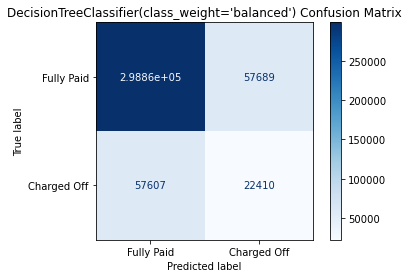

In [46]:
model_results(x_test_scaled,y_test,og_no,dtree)

In [ ]:
xgb2 = XGBRFClassifier(
 learning_rate =.5,
 n_estimators=250,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic', verbosity=1)

modelfit(xgb2, x_train_final, y_train_final,resamp,x_val,y_val)

In [ ]:
tree_params = {
  'colsample_bynode': 0.75,
  'learning_rate': 1,
  'max_depth': 2,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.75,
  'tree_method': 'auto'
}

In [ ]:
grid = GridSearchCV()

In [ ]:
xgb2 = XGBRFClassifier(
 learning_rate =.5,
 n_estimators=250,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic', verbosity=1)

modelfit(xgb2, x_train_final_z, y_train_final_z,resamp,x_val_z,y_val_z)